# Step 3

### Target:
- Use cutout augmentation technique to improve the model accuracy
- Use learning rate scheduler to achieve accuracy goals quicker

### Results:
- Parameters: 9,776
- Best Train Accuracy: 97.32%
- Best Test Accuracy: 99.47% (14th epoch)

### Analysis:
- After adding cutout augmentation, the model accuracy has improved
- Model accuracy got saturated around 99.35%, so increased the capacity of the model by increaseing the number of channels in the convolutional layers
- Model was able to achieve the target accuracy of 99.4+% consistently from 10th epoch

## Install Dependencies

In [1]:
!pip install torchsummary --quiet
!pip install tqdm --quiet
!pip install matplotlib --quiet

## Import Libraries

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt

## Import Model

In [3]:
from model_3 import Net

## Print Model Summary

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
              ReLU-2           [-1, 12, 26, 26]               0
       BatchNorm2d-3           [-1, 12, 26, 26]              24
           Dropout-4           [-1, 12, 26, 26]               0
            Conv2d-5           [-1, 14, 24, 24]           1,512
              ReLU-6           [-1, 14, 24, 24]               0
       BatchNorm2d-7           [-1, 14, 24, 24]              28
           Dropout-8           [-1, 14, 24, 24]               0
            Conv2d-9           [-1, 14, 22, 22]           1,764
             ReLU-10           [-1, 14, 22, 22]               0
      BatchNorm2d-11           [-1, 14, 22, 22]              28
          Dropout-12           [-1, 14, 22, 22]               0
           Conv2d-13           [-1, 10, 22, 22]             140
      BatchNorm2d-14           [-1, 10,

## Transformations for Training and Testing Datasets

In [5]:
# Train Dataset transformations
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomResizedCrop((28, 28), (0.85, 1.0)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),
    ])

# Test Dataset transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28, 28)),
    transforms.Normalize((0.1325,), (0.3104,))
    ])

## Training and Testing Datasets

In [6]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

## Training and Testing Dataloaders

In [7]:
SEED = 8

cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)

# Dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# Train & Test Dataloaders
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


## Data Statistics

/opt/conda/envs/pytorch/lib/python3.11/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8140)
 - mean: tensor(-0.0732)
 - std: tensor(0.7146)
 - var: tensor(0.5107)
torch.Size([64, 1, 28, 28])
torch.Size([64])


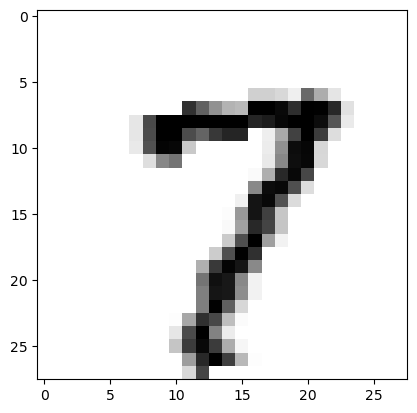

In [8]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

## Data Visualization

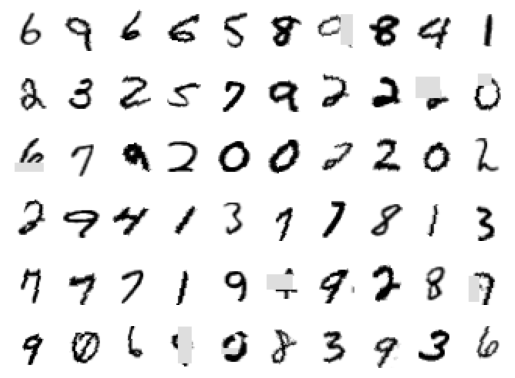

In [9]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Training and Testing Loops

In [10]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []


def train(model, device, train_loader, optimizer, epoch):
    """
    Training Loop
    :param model: Model
    :param device: Device
    :param train_loader: Training Dataloader
    :param optimizer: Optimizer
    :param epoch: Epoch number
    """
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # Get Samples
        data, target = data.to(device), target.to(device)

        # Set gradients to zero
        optimizer.zero_grad()

        # Predict
        output = model(data)

        # Calculate loss
        loss = F.nll_loss(output, target)
        train_losses.append(loss)

        # Backpropagation
        loss.backward()

        # Update weights
        optimizer.step()

        # Update pbar-tqdm
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'    Train set: Loss={loss.item():0.4f}, Accuracy: {100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    """
    Testing Loop
    :param model: Model
    :param device: Device
    :param test_loader: Testing Dataloader
    """
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_acc.append(100. * correct / len(test_loader.dataset))

    print('    Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

## Model Training and Testing

In [11]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
EPOCHS = 15

for epoch in range(1, EPOCHS + 1):
    print(f"Epoch {epoch}:")
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

Epoch 1:


    Train set: Loss=0.1596, Accuracy: 90.07: 100%|██████████| 938/938 [00:23<00:00, 40.07it/s]


    Test set: Average loss: 0.0653, Accuracy: 9837/10000 (98.37%)

Epoch 2:


    Train set: Loss=0.1423, Accuracy: 94.98: 100%|██████████| 938/938 [00:23<00:00, 40.36it/s]


    Test set: Average loss: 0.0399, Accuracy: 9895/10000 (98.95%)

Epoch 3:


    Train set: Loss=0.4426, Accuracy: 95.67: 100%|██████████| 938/938 [00:23<00:00, 40.42it/s]


    Test set: Average loss: 0.0311, Accuracy: 9914/10000 (99.14%)

Epoch 4:


    Train set: Loss=0.1620, Accuracy: 96.06: 100%|██████████| 938/938 [00:23<00:00, 40.67it/s]


    Test set: Average loss: 0.0330, Accuracy: 9900/10000 (99.00%)

Epoch 5:


    Train set: Loss=0.2765, Accuracy: 96.28: 100%|██████████| 938/938 [00:23<00:00, 40.40it/s]


    Test set: Average loss: 0.0255, Accuracy: 9926/10000 (99.26%)

Epoch 6:


    Train set: Loss=0.2457, Accuracy: 96.25: 100%|██████████| 938/938 [00:23<00:00, 40.47it/s]


    Test set: Average loss: 0.0286, Accuracy: 9908/10000 (99.08%)

Epoch 7:


    Train set: Loss=0.1979, Accuracy: 96.48: 100%|██████████| 938/938 [00:23<00:00, 40.39it/s]


    Test set: Average loss: 0.0215, Accuracy: 9938/10000 (99.38%)

Epoch 8:


    Train set: Loss=0.1530, Accuracy: 97.05: 100%|██████████| 938/938 [00:23<00:00, 40.55it/s]


    Test set: Average loss: 0.0217, Accuracy: 9938/10000 (99.38%)

Epoch 9:


    Train set: Loss=0.0268, Accuracy: 97.15: 100%|██████████| 938/938 [00:23<00:00, 40.55it/s]


    Test set: Average loss: 0.0206, Accuracy: 9938/10000 (99.38%)

Epoch 10:


    Train set: Loss=0.1174, Accuracy: 97.18: 100%|██████████| 938/938 [00:23<00:00, 40.40it/s]


    Test set: Average loss: 0.0207, Accuracy: 9943/10000 (99.43%)

Epoch 11:


    Train set: Loss=0.1156, Accuracy: 97.22: 100%|██████████| 938/938 [00:23<00:00, 40.64it/s]


    Test set: Average loss: 0.0205, Accuracy: 9941/10000 (99.41%)

Epoch 12:


    Train set: Loss=0.0986, Accuracy: 97.22: 100%|██████████| 938/938 [00:23<00:00, 40.56it/s]


    Test set: Average loss: 0.0200, Accuracy: 9941/10000 (99.41%)

Epoch 13:


    Train set: Loss=0.0374, Accuracy: 97.13: 100%|██████████| 938/938 [00:23<00:00, 40.24it/s]


    Test set: Average loss: 0.0197, Accuracy: 9945/10000 (99.45%)

Epoch 14:


    Train set: Loss=0.0250, Accuracy: 97.25: 100%|██████████| 938/938 [00:23<00:00, 39.89it/s]


    Test set: Average loss: 0.0199, Accuracy: 9947/10000 (99.47%)

Epoch 15:


    Train set: Loss=0.0188, Accuracy: 97.32: 100%|██████████| 938/938 [00:23<00:00, 39.98it/s]


    Test set: Average loss: 0.0198, Accuracy: 9944/10000 (99.44%)



## Plotting the Losses and Accuracies

Text(0.5, 1.0, 'Test Accuracy')

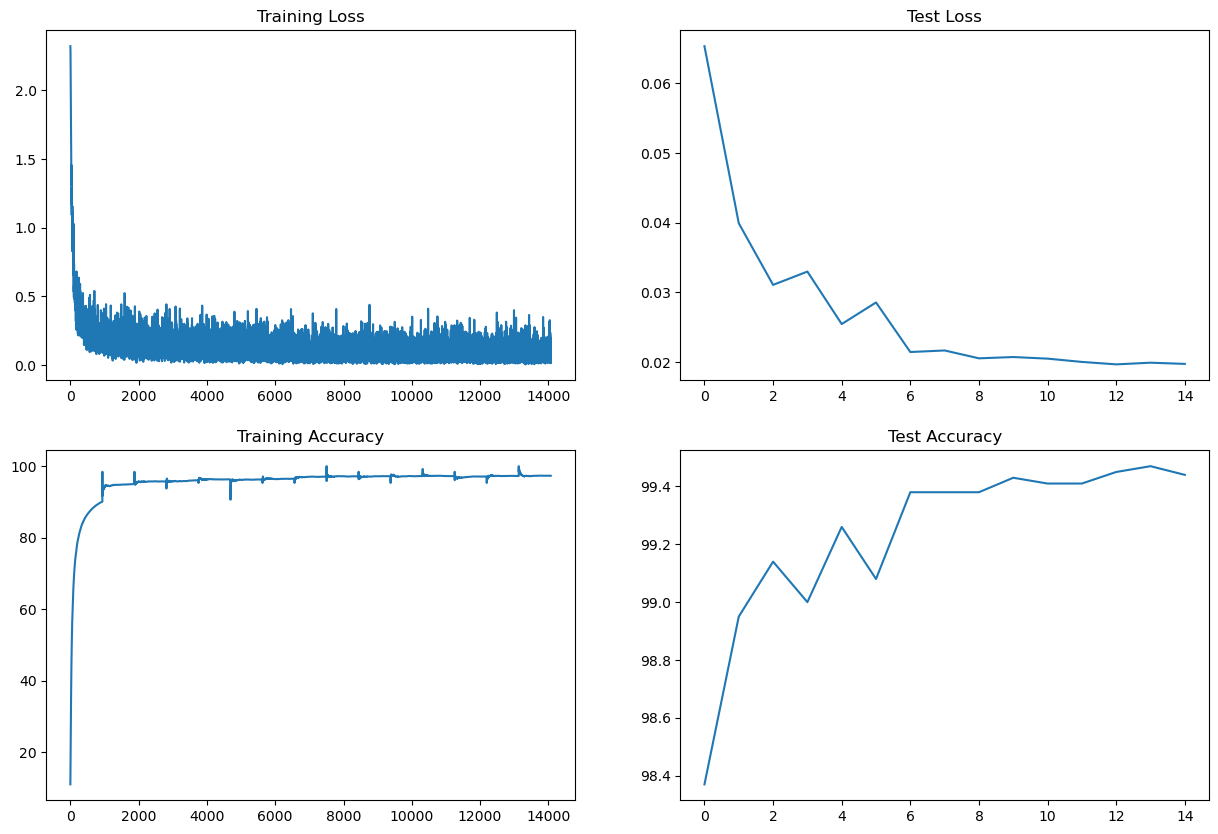

In [12]:
t = [t_items.item() for t_items in train_losses]

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Visualize Misclassified Images

In [13]:
def get_incorrect_imgs(model, device, test_loader):
    model.eval()
    incorrect_imgs = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            for image, label in zip(data, target):
              image = image.unsqueeze(0)
              output = model(image)
              pred = output.argmax(dim=1, keepdim=True)
              if pred != label:
                incorrect_imgs.append(image)

    return incorrect_imgs

In [14]:
incorrect_imgs = get_incorrect_imgs(model, device, test_loader)

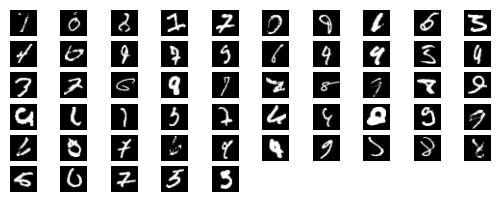

In [15]:
figure = plt.figure()
num_of_images = len(incorrect_imgs)

cpu_imgs = []
for gpu_img in incorrect_imgs:
  cpu_imgs.append(gpu_img.to('cpu'))

try:
  for index in range(1, num_of_images + 1):
      plt.subplot(12, 10, index)
      plt.axis('off')
      plt.imshow(cpu_imgs[index].numpy().squeeze(), cmap='gray')
except IndexError as error:
  pass